In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

# Code

In [2]:
# sucker = 0
# cheater = 1
def create_prison(dimension, cheater_ratio=0.5):
  prison = np.random.choice(
                              [0,1],
                              (dimension, dimension),
                              p=[1-cheater_ratio, cheater_ratio]
                            )
  return prison

In [3]:
# Play a single round with neighbors
# and a extra with self

# yes, this is way more complicated than it needs to be,
# but is slightly more performative than i+1 % J every access

@njit
def get_current_scores(prison, payoff):

  I, J = prison.shape
  score = np.empty((I, J))

  for i in range(I-1):
    for j in range(J-1):

      # play with self
      score[i,j] = payoff[prison[i,j], prison[i,j]]

      # play with neighbors
      score[i,j] += payoff[prison[i,j], prison[i-1,j]]
      score[i,j] += payoff[prison[i,j], prison[i+1,j]]
      score[i,j] += payoff[prison[i,j], prison[i,j-1]]
      score[i,j] += payoff[prison[i,j], prison[i,j+1]]

    j = J - 1

    # play with self
    score[i,j] = payoff[prison[i,j], prison[i,j]]

    # play with neighbors
    score[i,j] += payoff[prison[i,j], prison[i-1,j]]
    score[i,j] += payoff[prison[i,j], prison[i,j]]
    score[i,j] += payoff[prison[i,j], prison[i,j-1]]
    score[i,j] += payoff[prison[i,j], prison[i,0]]

    i = I - 1
    for j in range(J-1):

      # play with self
      score[i,j] = payoff[prison[i,j], prison[i,j]]

      # play with neighbors
      score[i,j] += payoff[prison[i,j], prison[i-1,j]]
      score[i,j] += payoff[prison[i,j], prison[0,j]]
      score[i,j] += payoff[prison[i,j], prison[i,j-1]]
      score[i,j] += payoff[prison[i,j], prison[i,j+1]]

    j = J - 1

    # play with self
    score[i,j] = payoff[prison[i,j], prison[i,j]]

    # play with neighbors
    score[i,j] += payoff[prison[i,j], prison[i-1,j]]
    score[i,j] += payoff[prison[i,j], prison[0,j]]
    score[i,j] += payoff[prison[i,j], prison[i,j-1]]
    score[i,j] += payoff[prison[i,j], prison[i,0]]

  return score


In [4]:
# Evolve prisoners strategies
@njit
def random_4():
  return int(np.random.random() * 4)

@njit
def compare_strategies(Ex, Ey, k):
  return 1.0 / (1.0 + np.exp((Ex - Ey) * k)) > np.random.random()

@njit
def evolve_strategy(prison, score, k):

  I, J = prison.shape
  strategy = prison.copy()

  for i in range(I-1):
    for j in range(J-1):

      y = random_4()

      if y == 0:
        if compare_strategies(score[i,j], score[i-1,j], k):
          strategy[i,j] = prison[i-1,j]

      elif y == 1:
        if compare_strategies(score[i,j], score[i+1,j], k):
          strategy[i,j] = prison[i+1,j]

      elif y == 2:
        if compare_strategies(score[i,j], score[i,j-1], k):
          strategy[i,j] = prison[i,j-1]

      else:
        if compare_strategies(score[i,j], score[i,j+1], k):
          strategy[i,j] = prison[i,j+1]

    j = J - 1
    y = random_4()

    if y == 0:
      if compare_strategies(score[i,j], score[i-1,j], k):
        strategy[i,j] = prison[i-1,j]

    elif y == 1:
      if compare_strategies(score[i,j], score[i+1,j], k):
        strategy[i,j] = prison[i+1,j]

    elif y == 2:
      if compare_strategies(score[i,j], score[i,j-1], k):
        strategy[i,j] = prison[i,j-1]

    else:
      if compare_strategies(score[i,j], score[i,0], k):
        strategy[i,j] = prison[i,0]

  i = I - 1
  for j in range(J-1):

    y = random_4()

    if y == 0:
      if compare_strategies(score[i,j], score[i-1,j], k):
        strategy[i,j] = prison[i-1,j]

    elif y == 1:
      if compare_strategies(score[i,j], score[0,j], k):
        strategy[i,j] = prison[0,j]

    elif y == 2:
      if compare_strategies(score[i,j], score[i,j-1], k):
        strategy[i,j] = prison[i,j-1]

    else:
      if compare_strategies(score[i,j], score[i,j+1], k):
        strategy[i,j] = prison[i,j+1]

  j = J - 1
  y = random_4()

  if y == 0:
    if compare_strategies(score[i,j], score[i-1,j], k):
      strategy[i,j] = prison[i-1,j]

  elif y == 1:
    if compare_strategies(score[i,j], score[0,j], k):
      strategy[i,j] = prison[0,j]

  elif y == 2:
    if compare_strategies(score[i,j], score[i,j-1], k):
      strategy[i,j] = prison[i,j-1]

  else:
    if compare_strategies(score[i,j], score[i,0], k):
      strategy[i,j] = prison[i,0]

  return strategy

In [5]:
@njit
def cheater_ratio(pop):
  return pop.mean()

# Simulation

In the prison, each cell will play against the neighbors in the grid (extremities connect to each other). After each prison each day, prisoners choose a random neighbor to compare their strategies against, and might either keep theirs or adopt the neighbor's strategy, becoming a sucker or cheater acordingly.

In [6]:
# set simulation parameters
frames = 10
steps_per_frame = 20
dimension = 200

initial_cheaters = 0.1  # between 0 and 1

# greater or equal to 0
payoff = np.array([ # against a... sucker | cheater  # while playing a...
                                       [2, 1],       # sucker
                                       [4, 0]        # cheater
                  ])

# affect the chance of keeping of changing strategy
# formula: p = 1 / 1 + e^((my score - neighbor's score) * learning weight)
learning_weight = 10

# Keep in mind that as learning gets close to 0, prisoners approach a 50%
# chance of changing/keeping regardless of score.

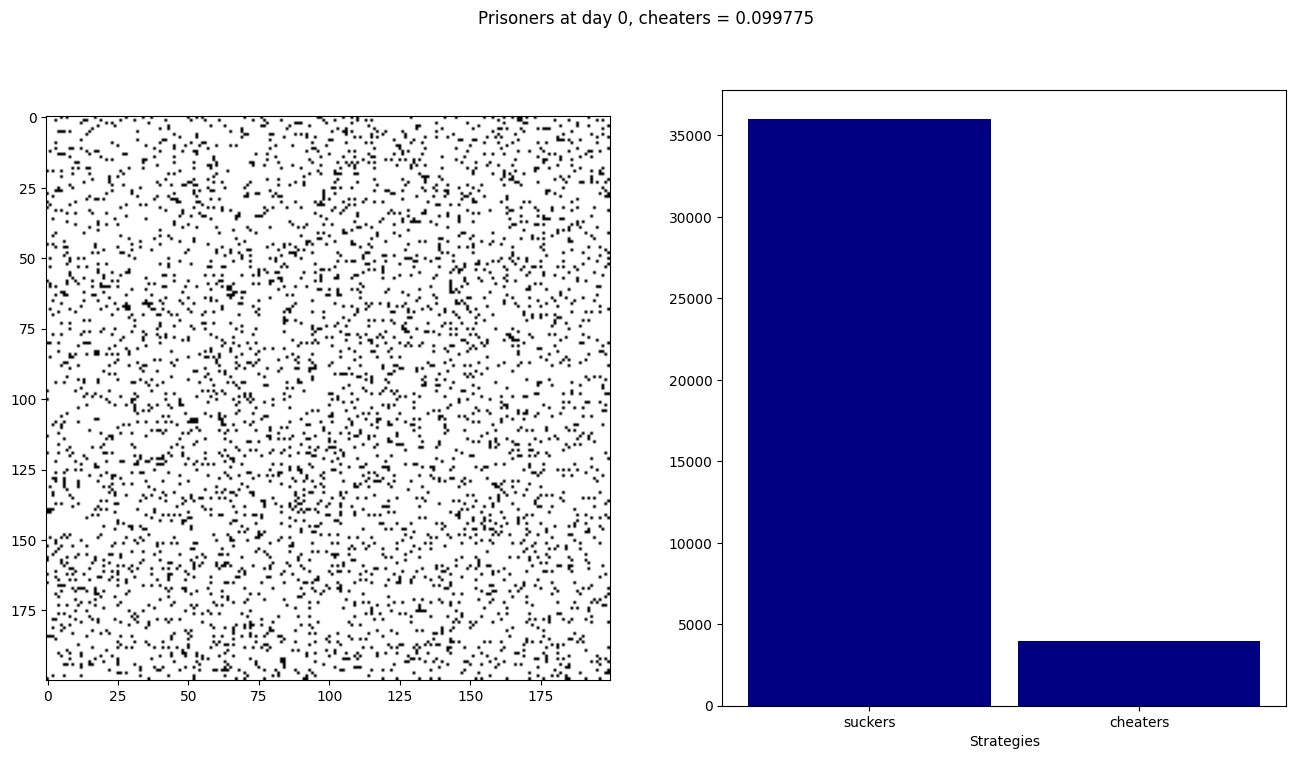

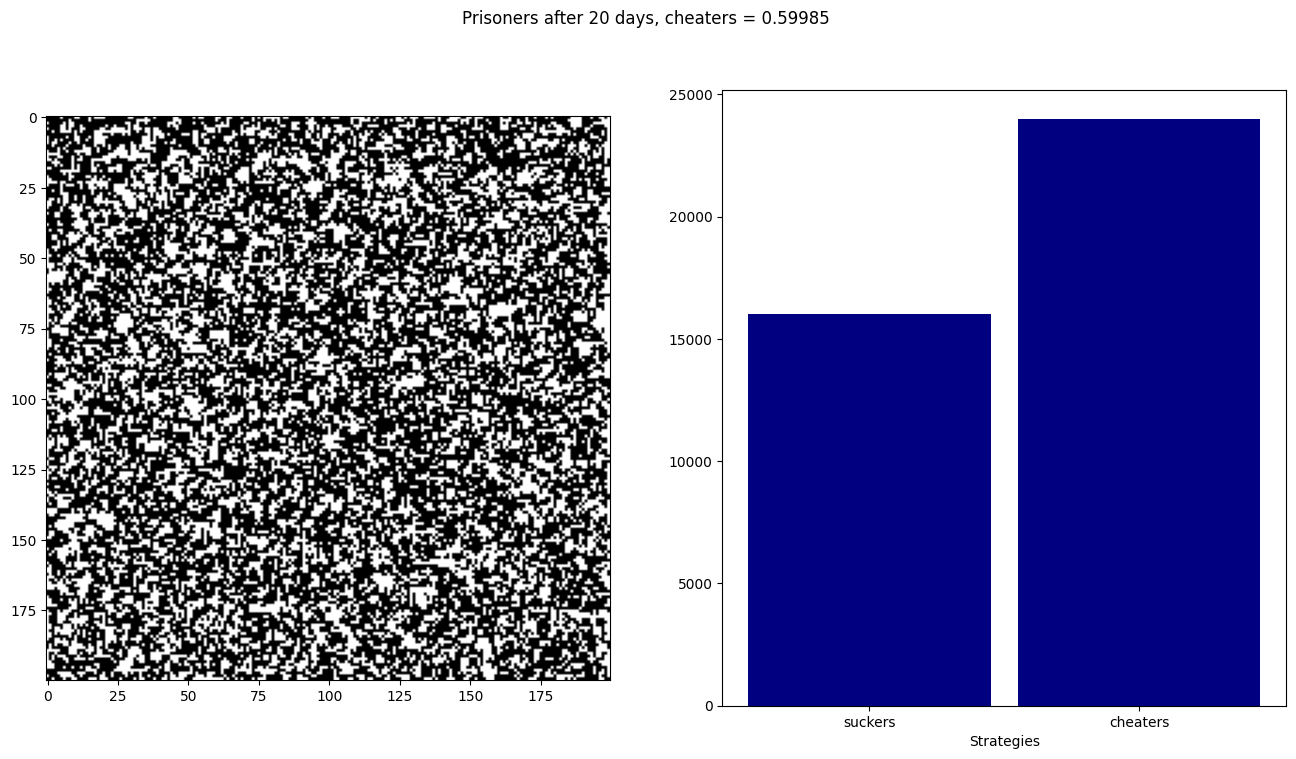

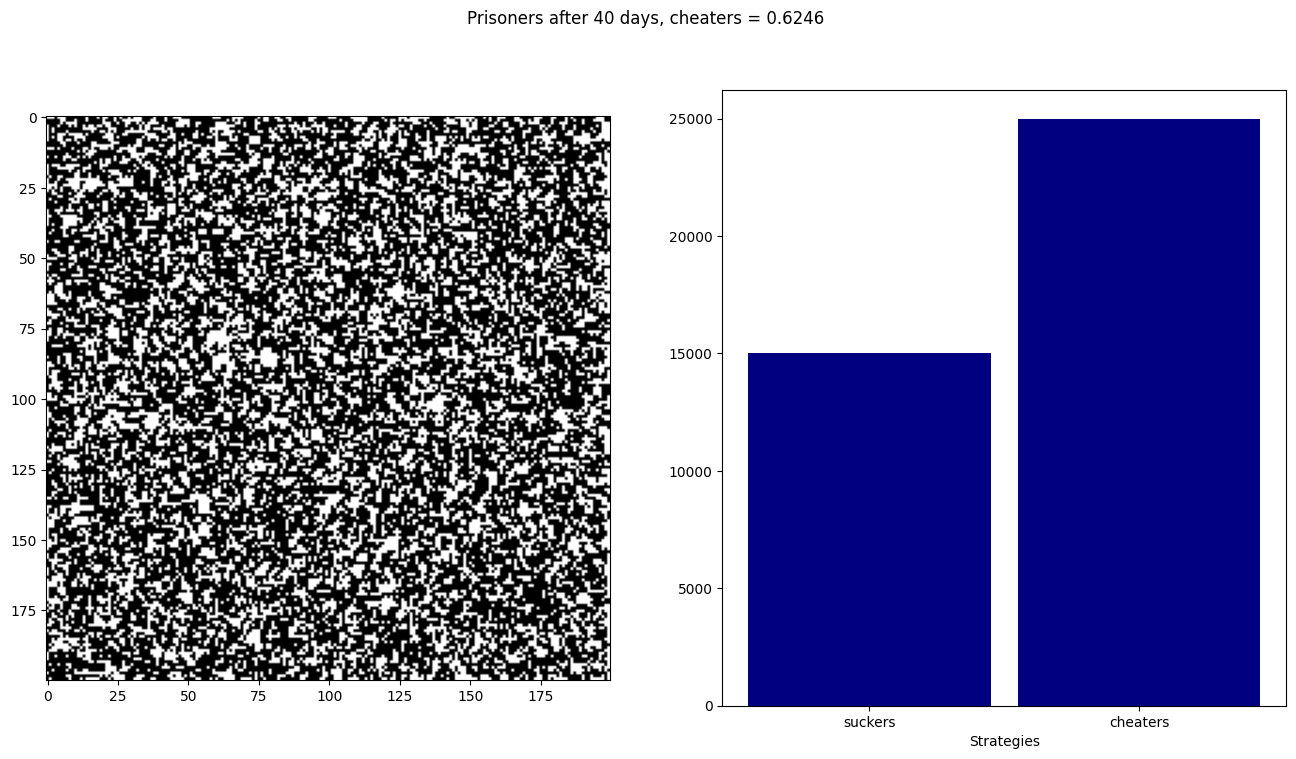

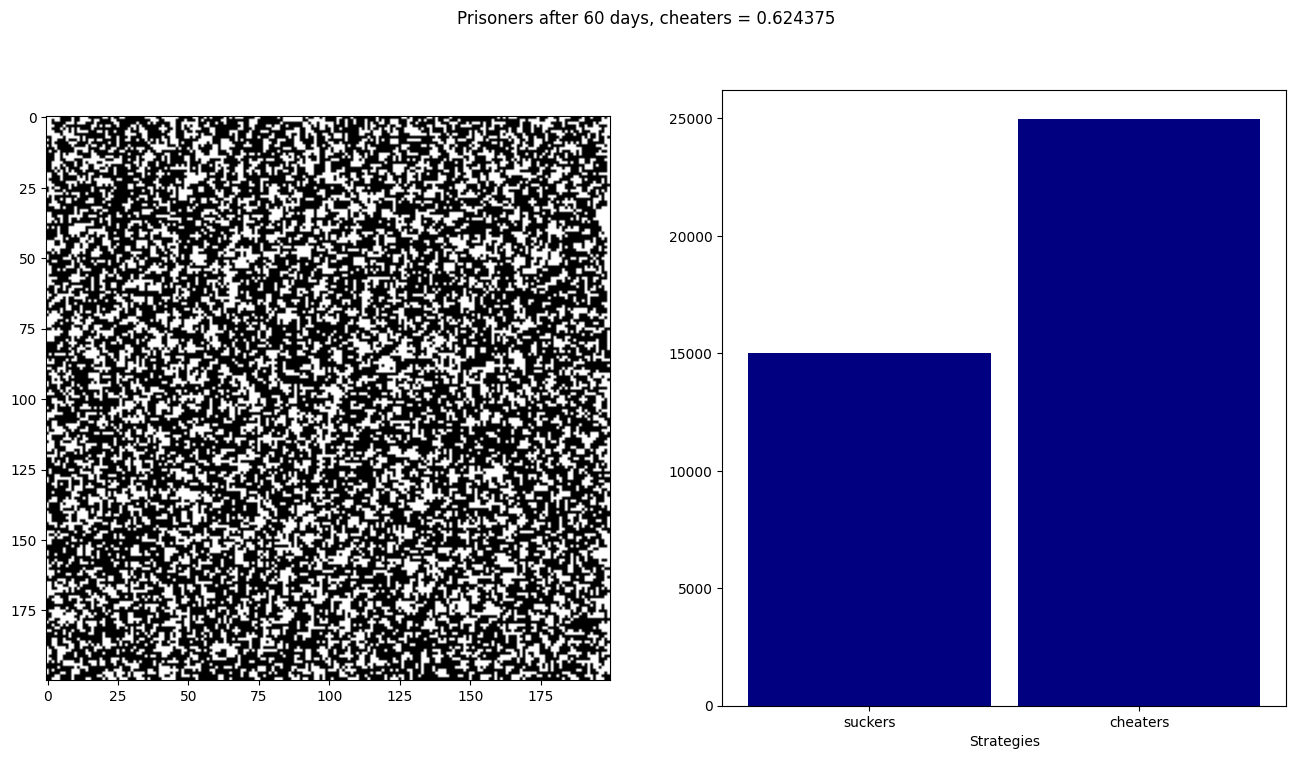

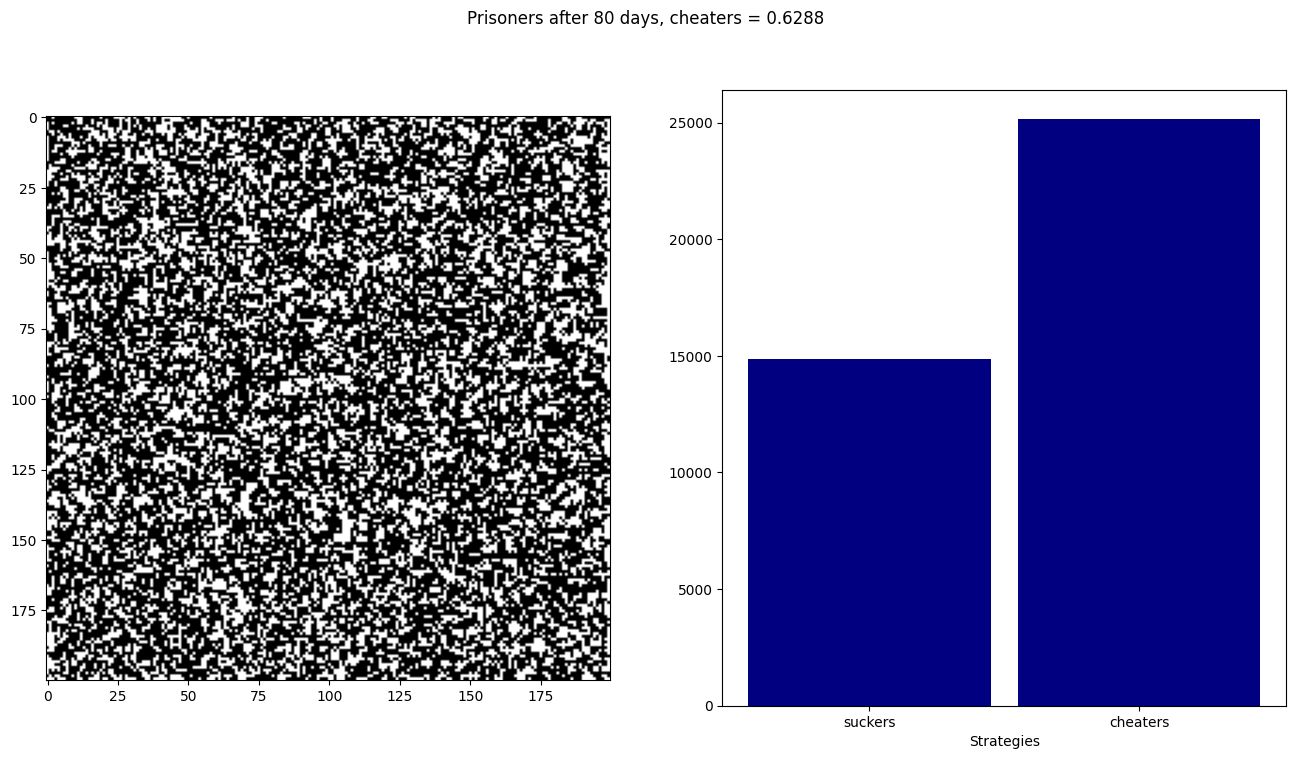

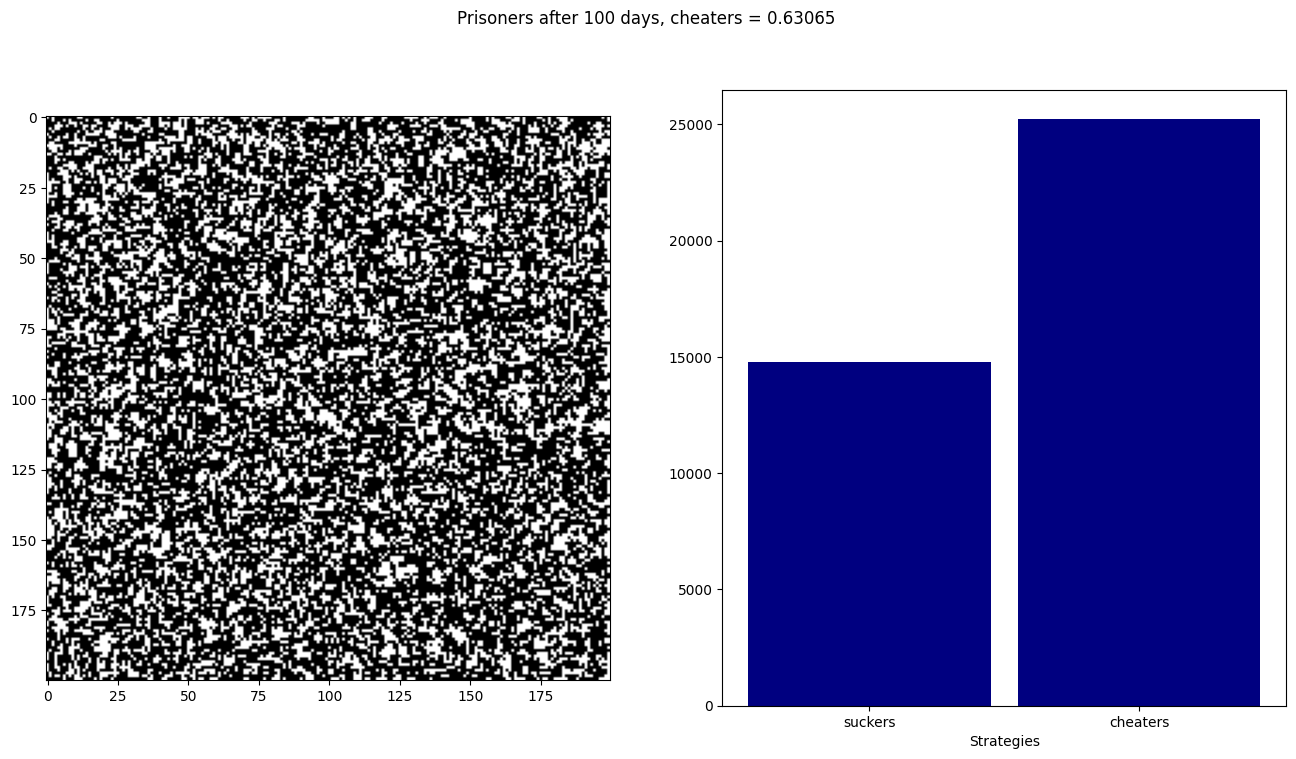

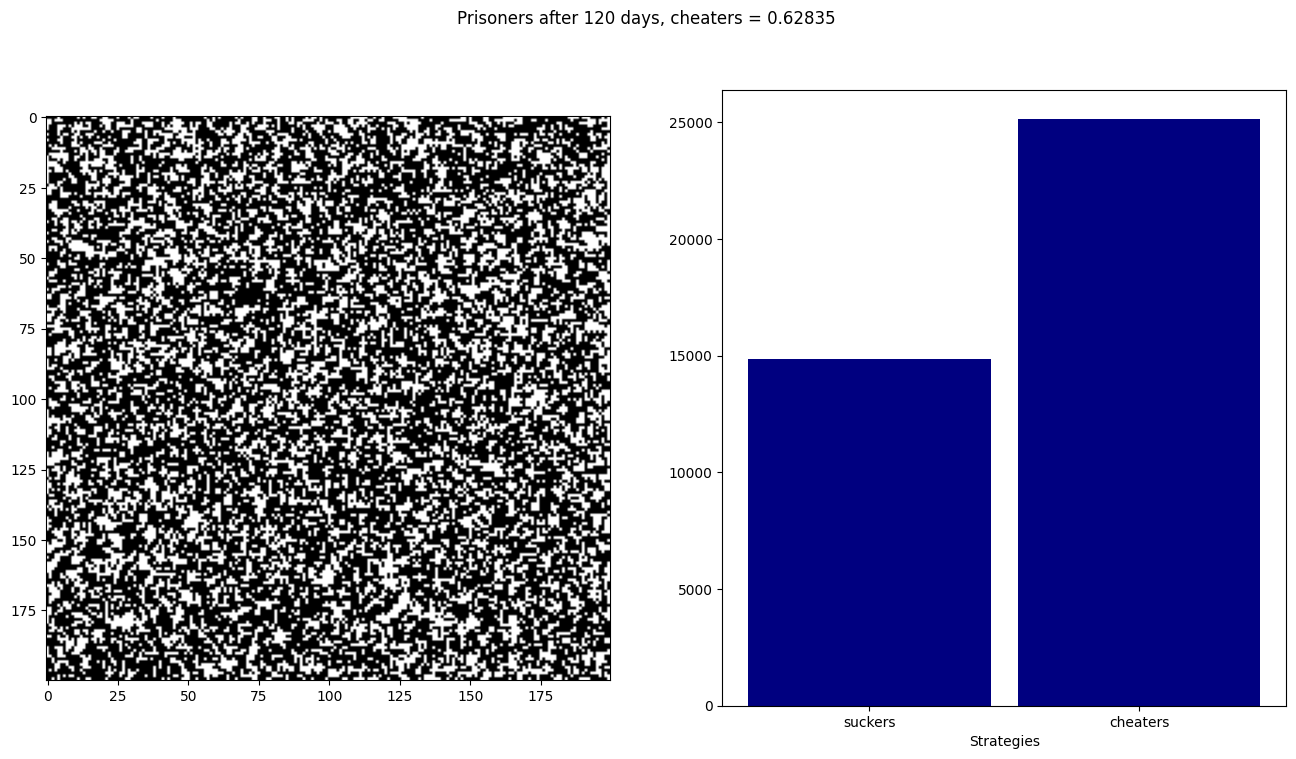

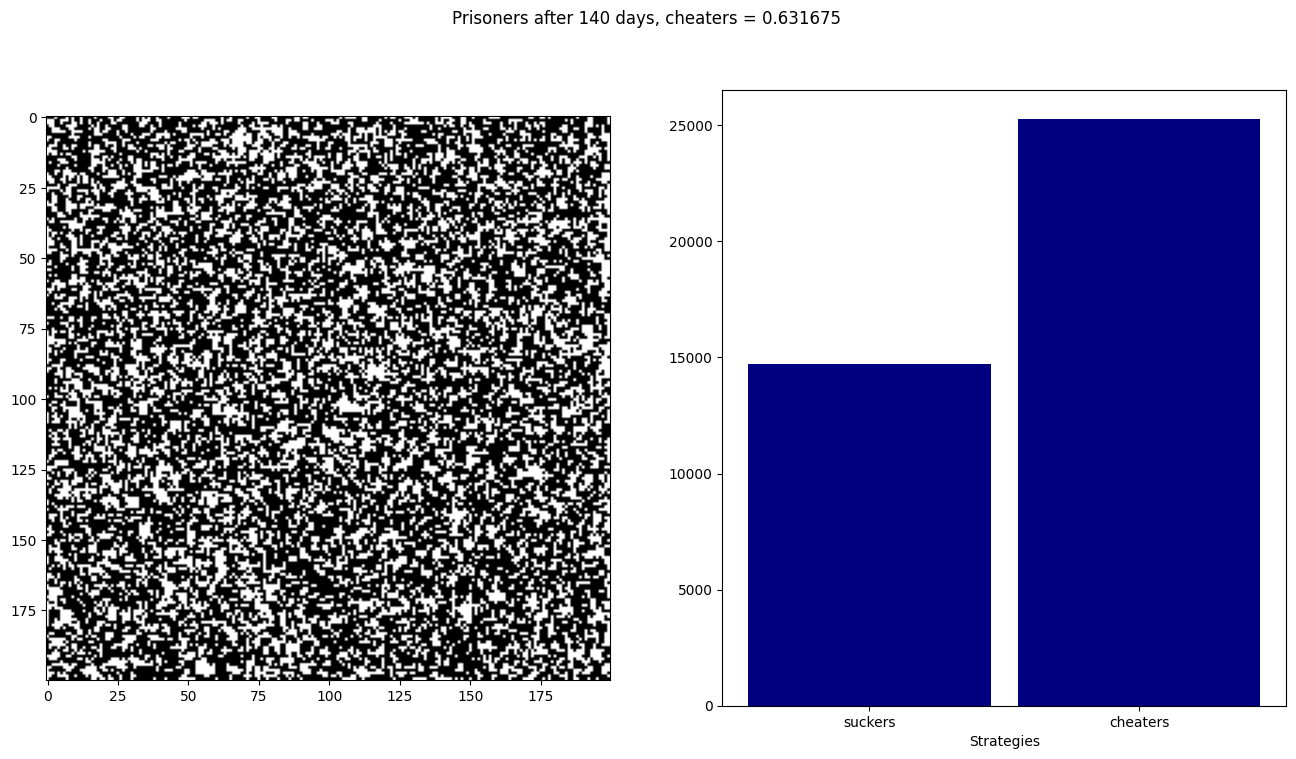

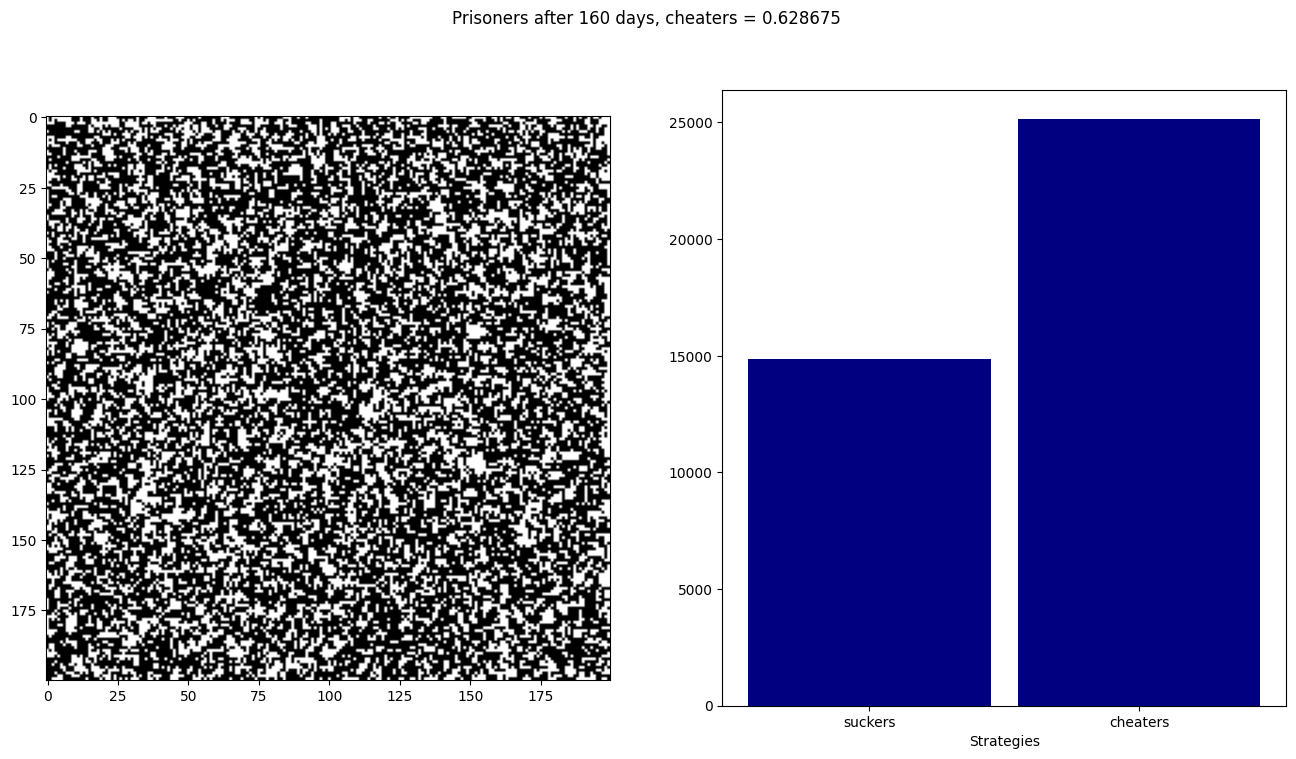

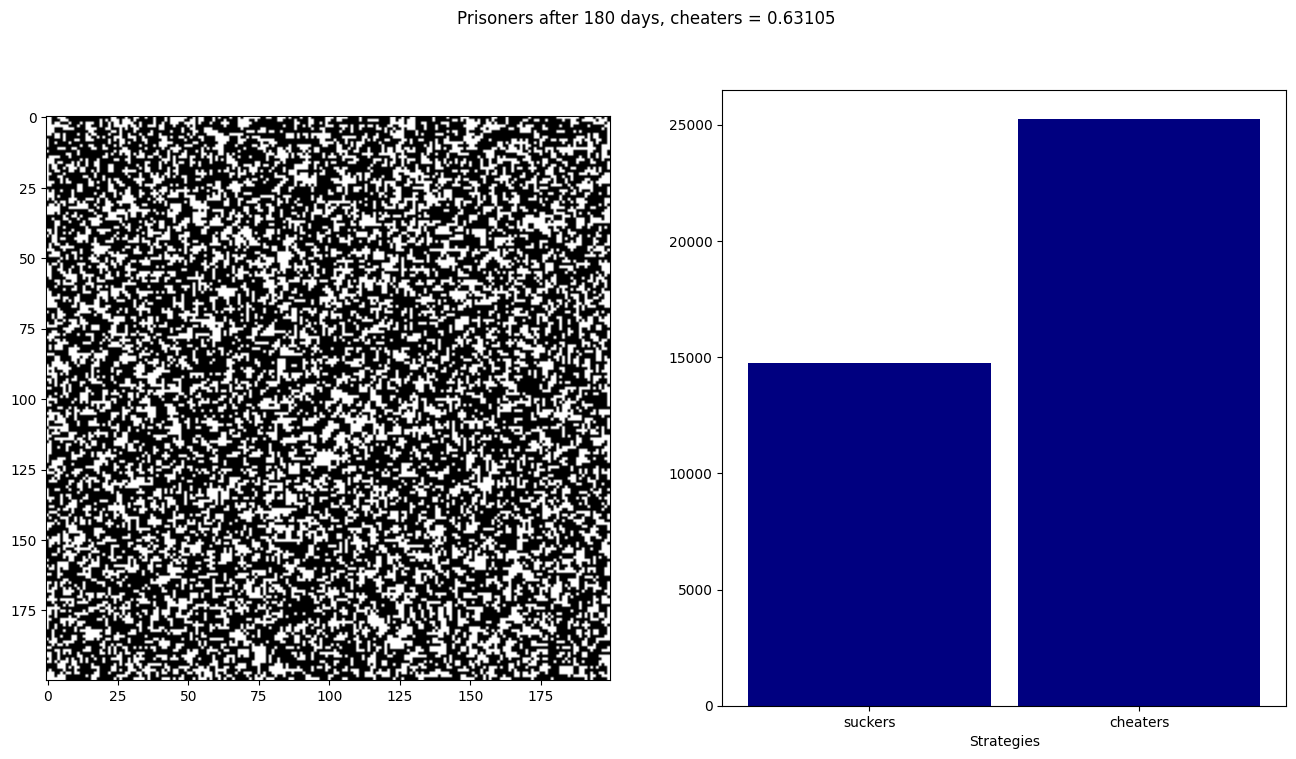

In [7]:
# run simulation

total = dimension ** 2
time = steps_per_frame * frames

fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

prison = create_prison(dimension, cheater_ratio=initial_cheaters)

ax1.imshow(prison, cmap='gray_r', vmin=0, vmax=1)

cheaters = prison.sum()
suckers = total - cheaters
width = 0.9

ax2.bar(['suckers', 'cheaters'], [suckers, cheaters], width, color='navy')
ax2.set_xlabel('Strategies')

fig.suptitle('Prisoners at day 0, cheaters = ' + str(cheater_ratio(prison)))

for days in range(steps_per_frame,time,steps_per_frame):

  fig = plt.figure(figsize = (16,8))
  ax1 = fig.add_subplot(121)
  ax2 = fig.add_subplot(122)

  for i in range(steps_per_frame):
    score = get_current_scores(prison, payoff)
    prison = evolve_strategy(prison, score, learning_weight)

  ax1.imshow(prison, cmap='gray_r', vmin=0, vmax=1)

  cheaters = prison.sum()
  suckers = total - cheaters
  width = 0.9

  ax2.bar(['suckers', 'cheaters'], [suckers, cheaters], width, color='navy')
  ax2.set_xlabel('Strategies')

  fig.suptitle('Prisoners after {} days, cheaters = {}'
                .format(days, cheater_ratio(prison))
              )

  plt.show()
